In [1]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import matplotlib.pyplot as plt

In [ ]:
# List of shapefiles
shapefile_path = 'fl_2016_congressional_districts/fl_2016_congressional_districts.shp'
population_data = 'tl_2016_12_tract/tl_2016_12_tract.shp'
votes_data = 'fl_2016/fl_2016.shp'

# Load the shapefiles into GeoDataFrames
region_gdf = gpd.read_file(shapefile_path)
population_gdf = gpd.read_file(population_data)
votes_gdf = gpd.read_file(votes_data)

# Define the bounds of the raster (based on all layers)
minx, miny, maxx, maxy = region_gdf.total_bounds


In [12]:
print(minx, miny, maxx, maxy)

-87.634896 24.396307999999998 -79.974306 31.000968


In [13]:
votes_gdf

,COUNTY,PRECINCT,PCT_STD,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PRECCAS,G16PREGSTE,G16PREODEL,G16PREOWRI,G16USSRRUB,G16USSDMUR,G16USSLSTA,G16USSNKHO,G16USSNNAT,G16USSNMAC,G16USSNDAL,G16USSOWRI,geometry
0,PUT,06,PUT0006,209,101,5,0,4,0,2,186,98,11,3,6,2,2,0,"POLYGON Z ((-81.5706 29.49875 0, -81.5706 29.4..."
1,PUT,01,PUT0001,330,304,13,1,3,0,7,352,273,11,5,6,2,0,0,"POLYGON Z ((-81.51449 29.45196 0, -81.51375 29..."
2,PUT,21,PUT0021,335,229,20,2,4,2,4,363,202,9,5,4,3,2,1,"POLYGON Z ((-81.87003 29.6286 0, -81.87 29.628..."
3,PUT,20,PUT0020,1083,601,30,1,10,3,8,1031,607,44,15,5,7,2,3,"POLYGON Z ((-81.94104 29.51234 0, -81.94115 29..."
4,PUT,18,PUT0018,1111,537,46,3,15,1,6,1094,519,51,3,13,5,5,1,"POLYGON Z ((-81.94545 29.65966 0, -81.94535 29..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6111,LAK,48,LAK0048,1206,902,53,2,19,1,0,1174,850,65,28,22,9,1,0,"POLYGON Z ((-81.69653 28.80324 0, -81.69582 28..."
6112,OSC,403,OSC0403,819,2091,69,10,17,7,41,1091,1791,54,10,23,12,7,8,"MULTIPOLYGON Z (((-81.39075 28.28959 0, -81.39..."
6113,OSC,999,OSC0999,7,52,0,0,1,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.33963 28.27865 0, -81.33962 28..."
6114,FLA,9,FLA0009,2526,1571,87,3,20,3,39,2398,1556,122,25,22,10,15,4,"POLYGON Z ((-81.19698 29.42524 0, -81.19744 29..."


Note the following codes:

G16PRERTRU - Donald Trump (Republican Party) <br/>
G16PREDCLI - Hillary Clinton (Democratic Party) <br/>
G16PRELJOH - Gary Johnson (Libertarian Party) <br/>
G16PRECCAS - Darrell Castle (Constitution Party) <br/>
G16PREGSTE - Jill Stein (Green Party) <br/>
G16PREODEL - Rocky De La Fuente (Reform Party) <br/>
G16PREOWRI - Write-In Votes

G16USSRRUB - Marco Rubio (Republican Party) <br/>
G16USSDMUR - Patrick Murphy (Democratic Party) <br/>
G16USSLSTA - Paul Stanton (Libertarian Party) <br/>
G16USSNKHO - Tony Khoury (No Party Affiliation) <br/>
G16USSNNAT - Bruce Nathan (No Party Affiliation) <br/>
G16USSNMAC - Steven Machat (No Party Affiliation) <br/>
G16USSNDAL - Basil E. Dalack (No Party Affiliation) <br/>
G16USSOWRI - Write-In Votes

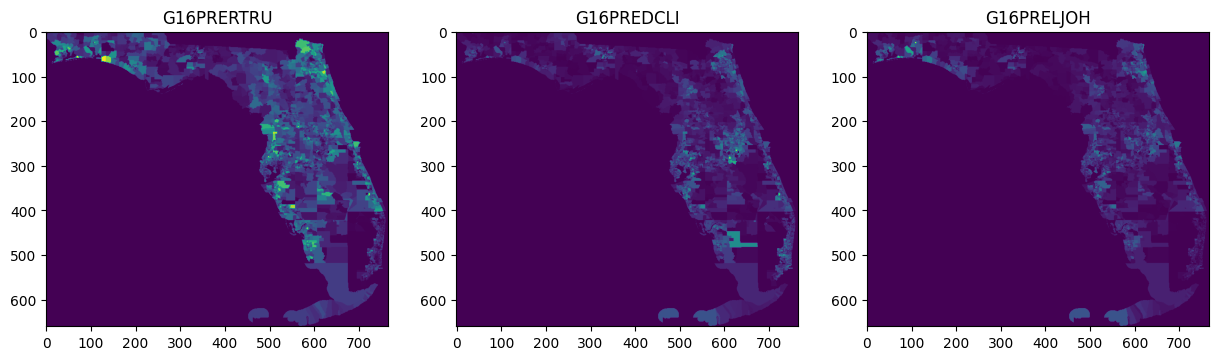

In [15]:
selected_columns = ['G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH']

votes_selected = votes_gdf[selected_columns + ['geometry']]

# Step 2: Define the bounds and raster properties (use the extent of the whole shapefile)
minx, miny, maxx, maxy = votes_gdf.total_bounds
pixel_size = 0.01
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Set up the transform for the raster
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Step 3: Rasterize each attribute column separately into bands
raster_bands = []

for col in selected_columns:
    shapes = ((geom, value) for geom, value in zip(votes_gdf.geometry, votes_gdf[col]))
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'  # Using float to handle potentially varying scales of different attributes
    )
    raster_bands.append(raster_band)

fig, axs = plt.subplots(1, len(selected_columns), figsize=(15, 5))
for i, band in enumerate(raster_bands):
    axs[i].imshow(band, cmap='viridis')
    axs[i].set_title(f'{selected_columns[i]}')
plt.show()

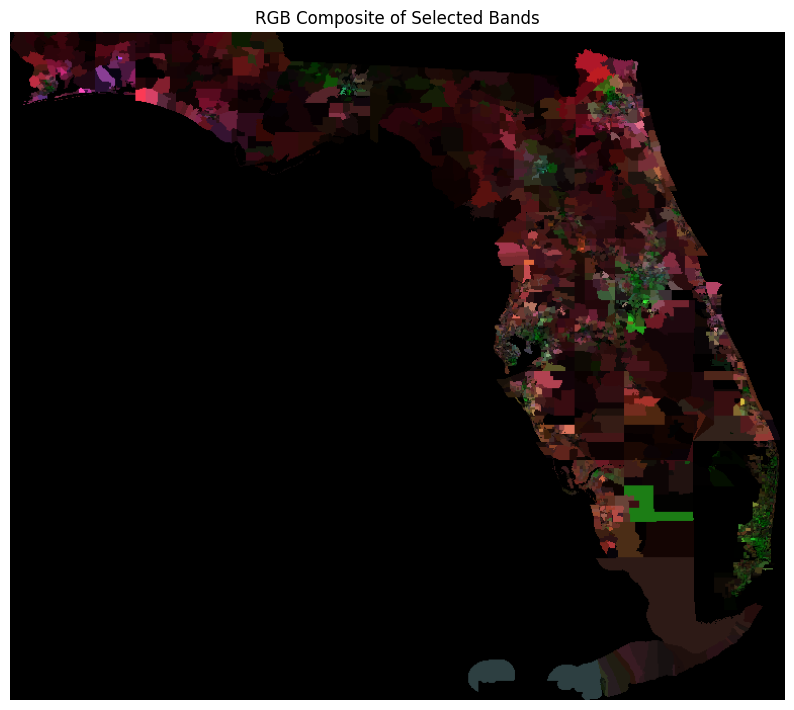

In [16]:
if len(raster_bands) >= 3:
    # Select bands for RGB visualization
    red_band = raster_bands[0]
    green_band = raster_bands[1]
    blue_band = raster_bands[2]

    # Normalize bands to [0, 1] for visualization
    def normalize(array):
        return (array - array.min()) / (array.max() - array.min())

    red_norm = normalize(red_band)
    green_norm = normalize(green_band)
    blue_norm = normalize(blue_band)

    # Stack the bands to create an RGB image
    rgb = np.dstack((red_norm, green_norm, blue_norm))

    # Plot the RGB image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.title('RGB Composite of Selected Bands')
    plt.axis('off')
    plt.show()
else:
    print("Not enough bands available for RGB visualization. Please select at least three attributes.")

# OTHER CODE

In [ ]:
# Define the raster resolution
pixel_size = 0.01
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Set up the transform for the raster
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Create empty arrays for each of the attributes you want to store
# Band 1: Regions (Layer 1)
# Band 2: Population (Layer 2)
# Band 3: Votes (Layer 3)
regions_raster = rasterize(
    ((geom, 1) for geom in region_gdf.geometry),
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

population_raster = rasterize(
    ((geom, population_value) for geom, population_value in zip(population_gdf.geometry, population_gdf['population'])),
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='int32'
)

votes_raster = rasterize(
    ((geom, votes_value) for geom, votes_value in zip(votes_gdf.geometry, votes_gdf['votes'])),
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='int32'
)

In [ ]:
# Optional: Visualize the different bands
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(regions_raster, cmap='gray')
axs[0].set_title('Regions')
axs[1].imshow(population_raster, cmap='viridis')
axs[1].set_title('Population')
axs[2].imshow(votes_raster, cmap='plasma')
axs[2].set_title('Votes')
plt.show()